In [1]:
import warnings
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import stan
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RNASEQ_DATA_URL = "https://raw.githubusercontent.com/ucdavis-bioinformatics-training/2018-June-RNA-Seq-Workshop/master/thursday/all_counts.txt"

In [3]:
rnaseq_df = (
    pd.read_csv(RNASEQ_DATA_URL, sep="\t").
        transpose().
        astype("int64").
        reset_index().
        rename(columns={"index": "sample_id"})
)

In [4]:
rnaseq_df["cultivar"] = [s[0:1] if s.startswith("C") else s[0:2] for s in rnaseq_df["sample_id"]]
rnaseq_df["replicate"] = rnaseq_df["sample_id"].str[-1]
rnaseq_df["time"] = [s[1:-1] if s.startswith("C") else s[2:-1] for s in rnaseq_df["sample_id"]]

metadata_cols = ["sample_id", "cultivar", "replicate", "time"]
gene_cols = [col for col in rnaseq_df if not col in metadata_cols]

In [5]:
print(rnaseq_df.shape)
rnaseq_df.iloc[0:5, 0:5]

(24, 34266)


,sample_id,AT1G01010,AT1G01020,AT1G03987,AT1G01030
0,C61,289,127,0,17
1,C62,317,78,0,25
2,C63,225,142,0,32
3,C64,343,130,0,24
4,C91,325,156,0,22


<Figure size 432x288 with 0 Axes>

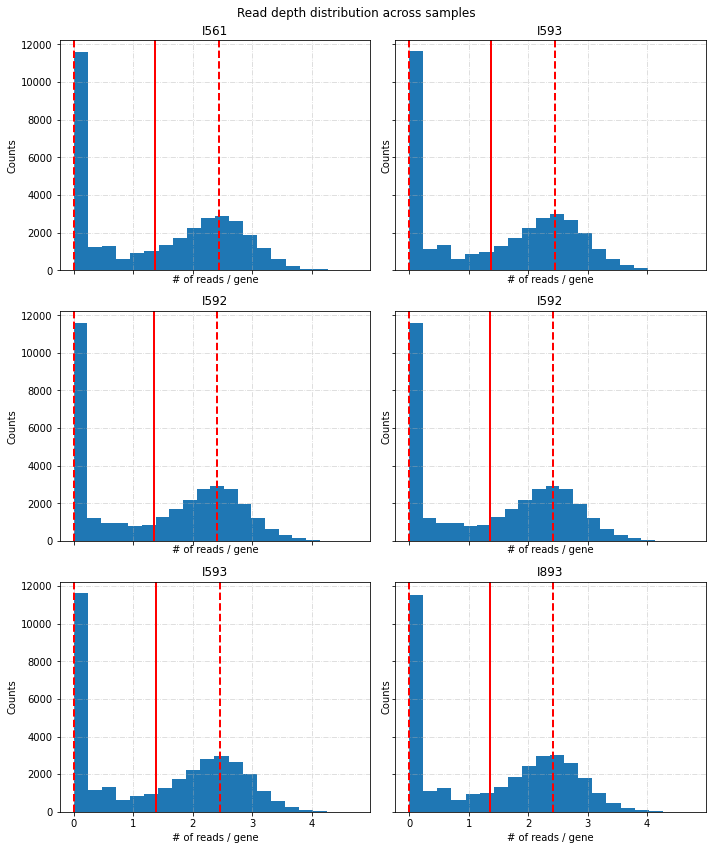

In [52]:
plt.figure()

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey=True, sharex=True)
fig.suptitle("Read depth distribution across samples")

samples_to_plot = np.random.choice(rnaseq_df["sample_id"], size=6)

for idx, ax in enumerate(chain(*axes)):
    sample = samples_to_plot[idx]
    log_read_depth = np.log10(1 + rnaseq_df.query("sample_id == @sample")[gene_cols].values.flatten())
    ax.hist(log_read_depth, density=False, bins=20)
    ax.axvline(log_read_depth.mean(), linewidth=2, color="red")
    for iqr in np.quantile(log_read_depth, [0.25, 0.75]):
        ax.axvline(iqr, linewidth=2, color="red", linestyle="--")
    ax.grid(alpha=0.5, linestyle="-.")
    ax.set_title(sample)
    ax.set_ylabel("Counts")
    ax.set_xlabel("# of reads / gene")
plt.tight_layout()

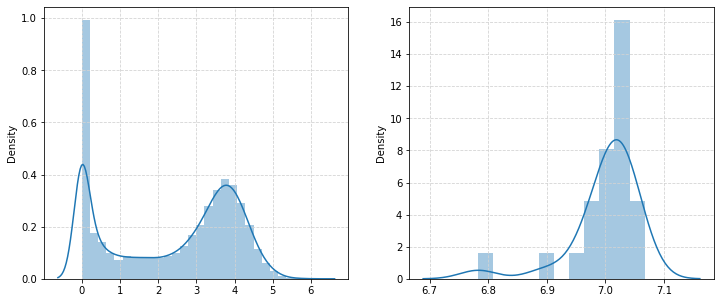

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.distplot(np.log10(1 + rnaseq_df[gene_cols].sum(axis=0)))
plt.grid(linestyle="--", color="lightgray")

plt.subplot(1, 2, 2)
sns.distplot(np.log10(rnaseq_df[gene_cols].sum(axis=1)))
plt.grid(linestyle="--", color="lightgray")


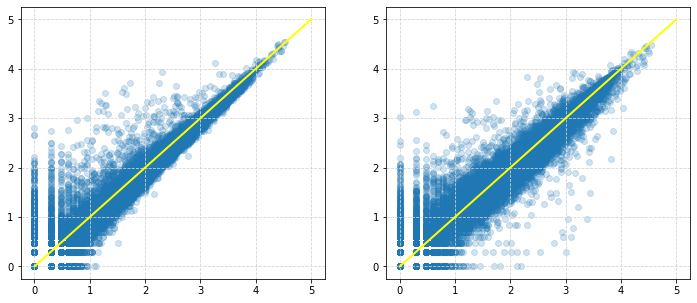

In [55]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C61"][gene_cols].values),
    y=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C62"][gene_cols].values),
    alpha=0.2
)
plt.grid(linestyle="--", color="lightgray")
plt.plot(np.linspace(0, 5, 25), np.linspace(0, 5, 25), color="yellow", linewidth=2)

plt.subplot(1, 2, 2)
plt.scatter(
    x=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C61"][gene_cols].values),
    y=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C91"][gene_cols].values),
    alpha=0.2
)
plt.grid(linestyle="--", color="lightgray")
plt.plot(np.linspace(0, 5, 25), np.linspace(0, 5, 25), color="yellow", linewidth=2)


In [57]:
gene_samp_code = """
data {
  int<lower=0> num_genes;  // number of genes
  int<lower=0> num_samps;  // number of samples
  // int<lower=0> num_cultivars;  // number of cultivars
  // int<lower=0> num_times;  // number of times
  // int<lower=0> cultivars[num_samps];
  // int<lower=0> times[num_samps];
  int<lower=0> counts[num_samps, num_genes]; // read counts
}
parameters {
  vector[num_genes] mu_gene;
  vector[num_samps] mu_samp; 
  // matrix[num_] beta_cultivar[num_cultivars];
  // real beta_time[num_times];
}
model {
  //for(s in 1:num_samps) {
    // mu_samp[s] = beta_cultivar[cultivars[s]] + 
    for(s in 1:num_samps) {
      counts[s] ~ poisson(exp(mu_samp[s] + mu_gene));
    }
  //}
}
"""

stan_data = {
    "num_genes": len(gene_cols),
    "num_samps": rnaseq_df.shape[0],
    "counts": rnaseq_df[gene_cols]
}